In [14]:
%load_ext autoreload
%autoreload 2
from paths import *

from matplotlib import pyplot as plt
import torch
from src.SERS_dataset import IterDataset
from src.generate_data2 import pseudoVoigtSimulatorTorch
from src.plotting.save_plot import save_plot
from src.plotting.VAE_plotting import plot_loss, plt_latent_space_ellipses, plt_reconstructions, plot_losses, plot_losses_3_2
from src.models.vanilla_VAE import VariationalAutoencoder
# import make_axes_locatable
import numpy as np
import dill
import io

# matplotlib style seaborn-whitegrid
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\andre\AppData\Local\Temp\ipykernel_15392\3176252513.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [9]:
# load model that has been trained on GPU on CPU. Source https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(dill.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def load_dill(file_name, experiment):
    file_name = os.path.join(results_dir, experiment, file_name)
    with open(file_name, 'rb') as f:
        contents = CPU_Unpickler(f).load()
    autoencoder = contents["model"]
    train_loss = contents["train_loss"]
    generator_num = contents["generator"]

    return autoencoder, train_loss, generator_num

In [16]:
# model_names = {"winter-galaxy-574": 3, "star-speeder-330": 2, "scruffy-looking-ewok-309": 1}
models = ["winter-galaxy-574", "northern-plant-578", "deft-serenity-581"]
labels_dict = {1: "alpha", 2: "c", 3: ["c", "alpha"]}

In [11]:
ps = pseudoVoigtSimulatorTorch(500)

Generator 1 (winter-galaxy-574)
   loss 367.59937078302556
   kl 4.212049700997093
   elbo -367.59937078302556
   logpx -363.38732355291194
   MSE 0.2504916489124298
   MSE 0.24752633273601532 (validation batch)


Generator 2 (northern-plant-578)
   loss 377.90877186168325
   kl 10.003033291209828
   elbo -377.90877186168325
   logpx -367.90573952414775
   MSE 0.25501008467240766
   MSE 0.25290292501449585 (validation batch)


Generator 3 (deft-serenity-581)
   loss 390.4060974121094
   kl 11.497034939852627
   elbo -390.4060974121094
   logpx -378.90909090909093
   MSE 0.26601341366767883
   MSE 0.2635834813117981 (validation batch)




<Figure size 1500x700 with 0 Axes>

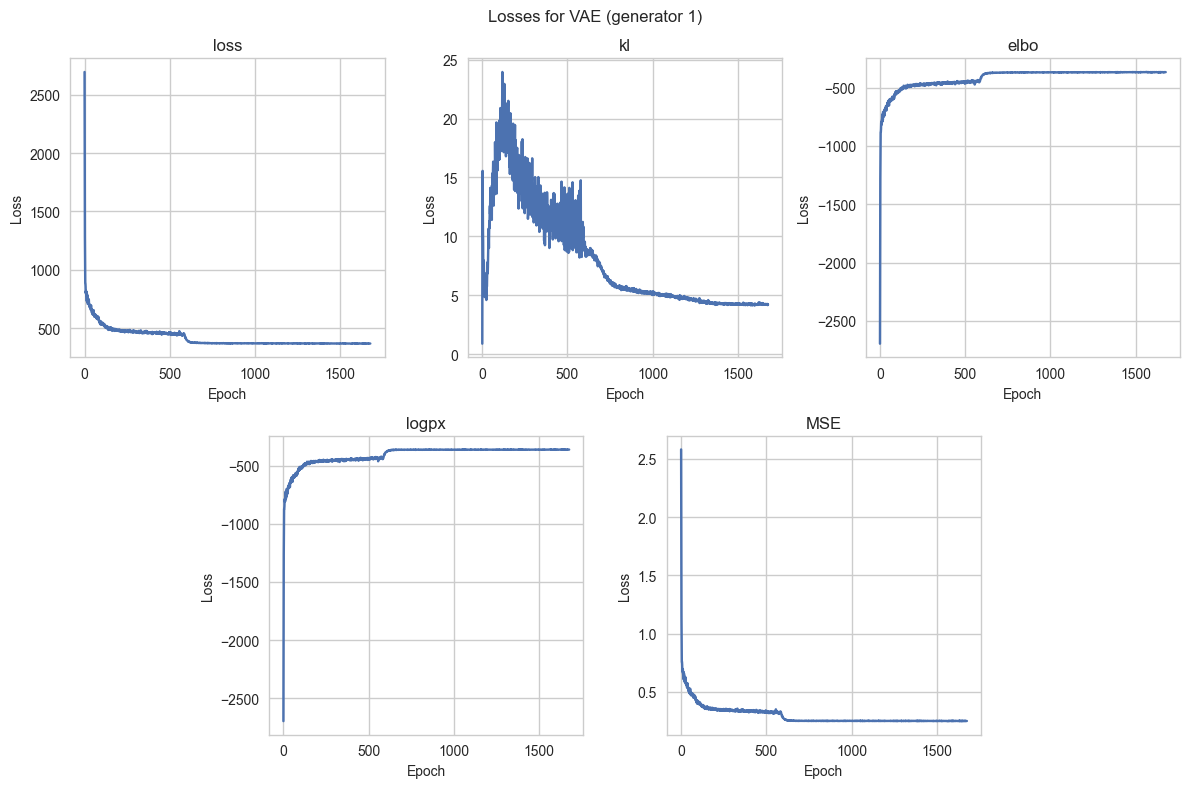

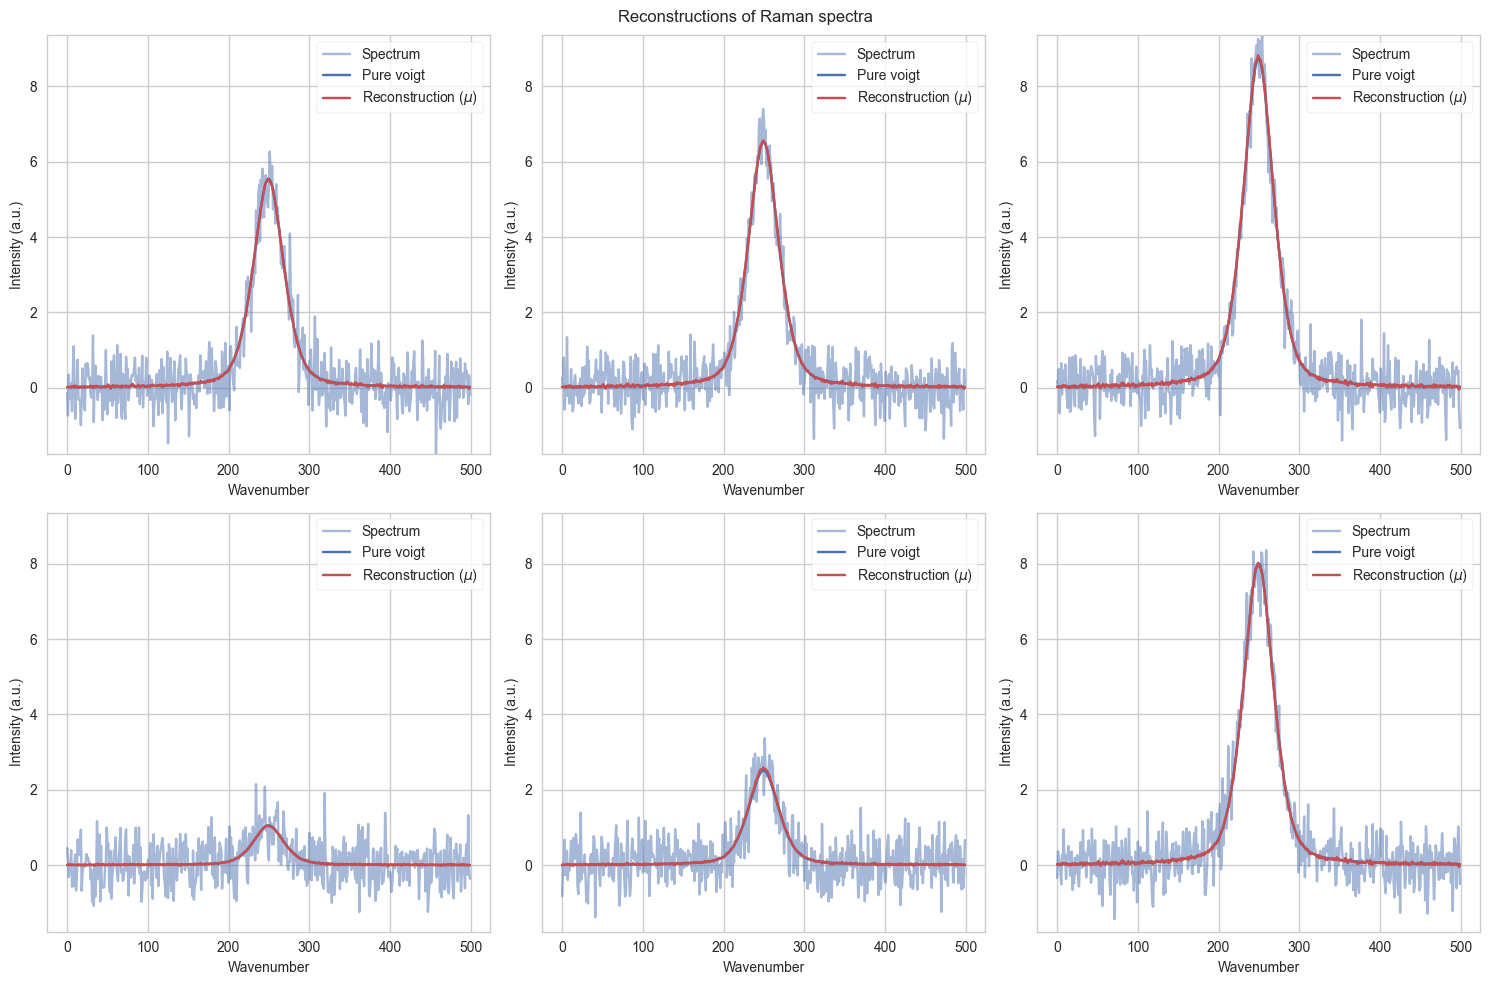

<Figure size 1500x700 with 0 Axes>

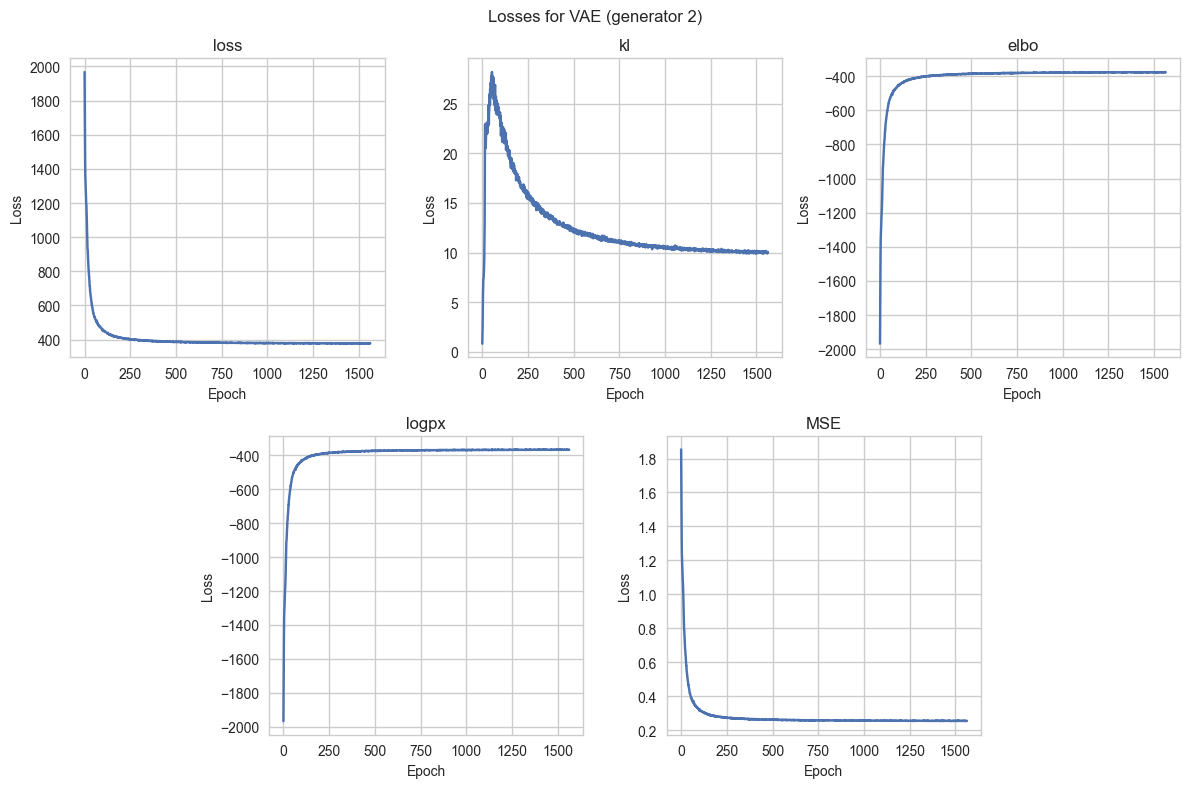

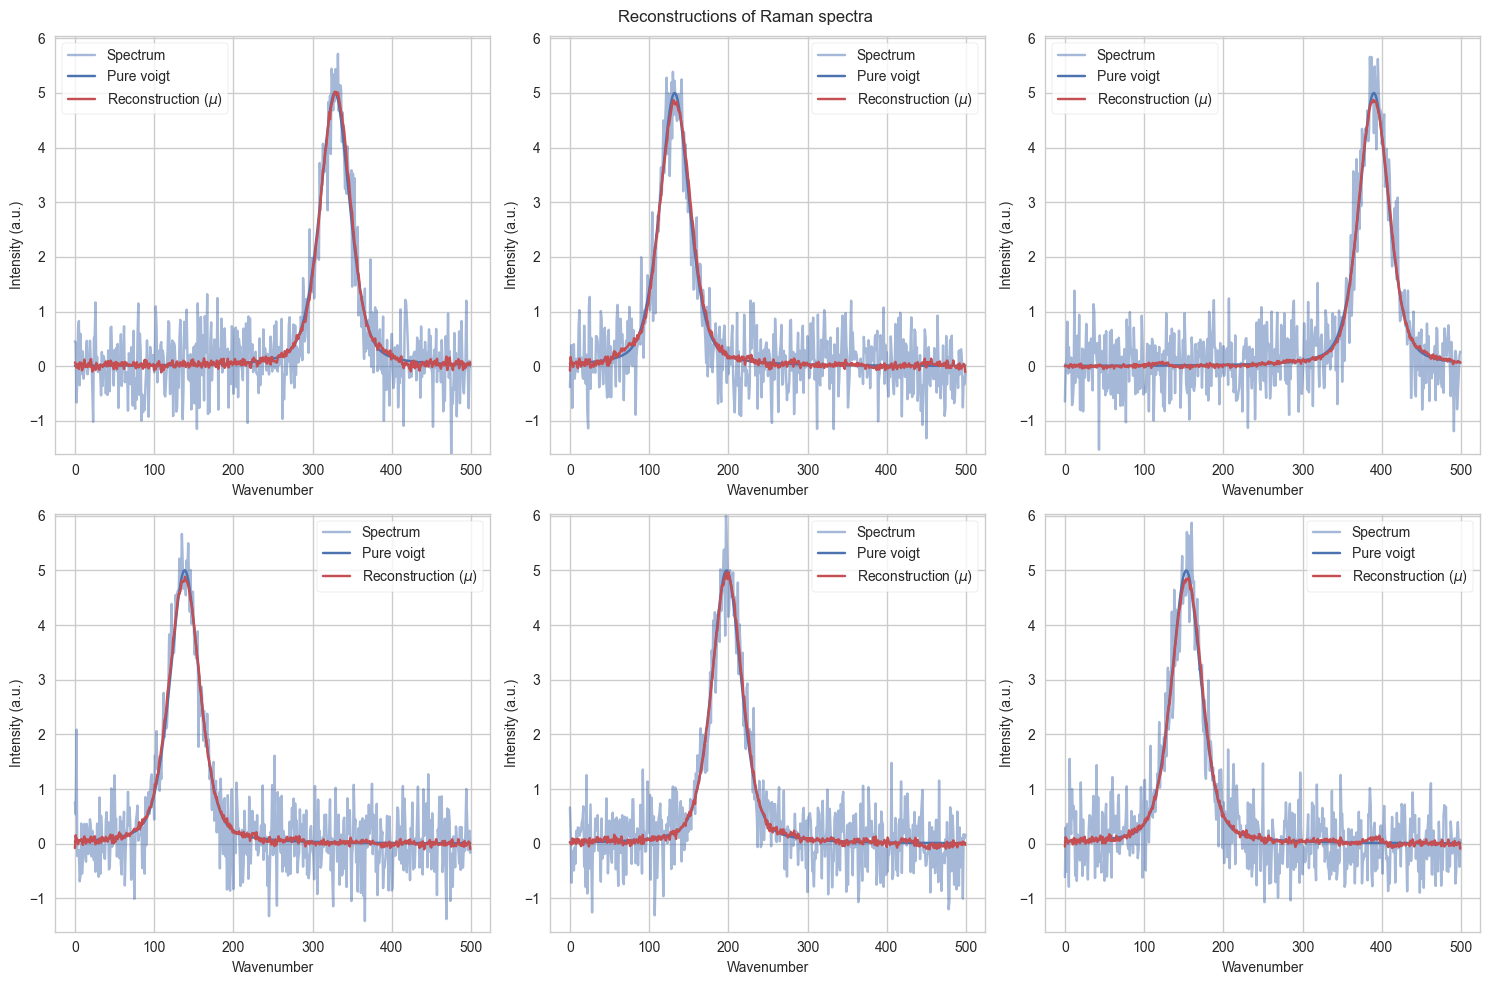

<Figure size 1500x700 with 0 Axes>

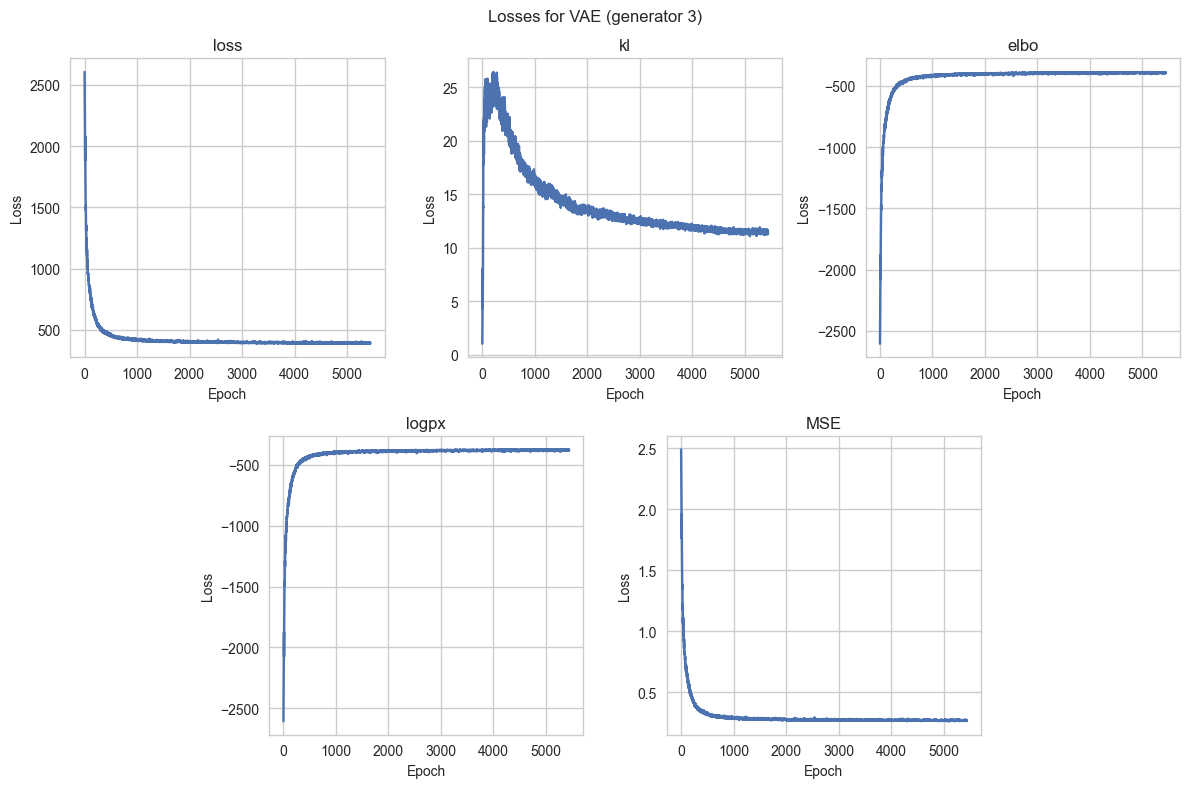

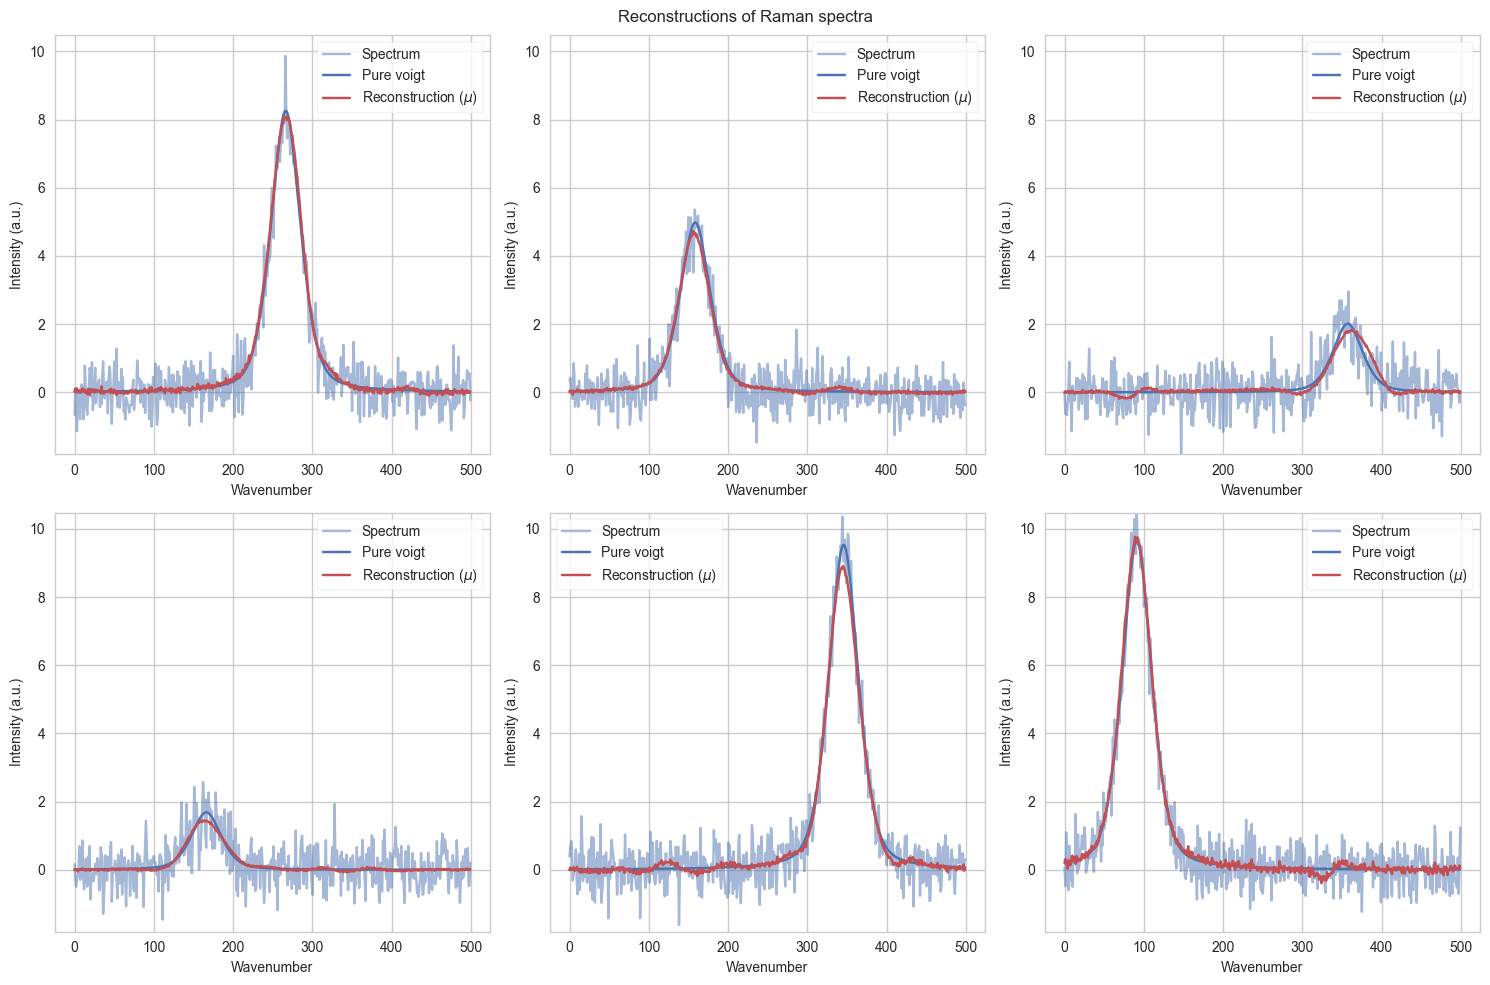

In [17]:
# don't show plots in notebook
# plt.ioff()

for model_name in models:

    autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "2_VAE")

    print("Generator", generator_num, "(" + model_name + ")")
    for key, value in train_loss.items():
        print("  ", key, value[-1])

    # print("Generator", generator_num, ", Loss: ", train_loss[-1])

    generator = ps.predefined_generator(generator_num)
    dset_train = IterDataset(generator)
    train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, pin_memory=cuda)

    x, y = next(iter(train_loader))
    x = x.to(device)
    y = y.to(device)
    z, mu, logvar = autoencoder.encode(x)
    sigma = torch.exp(0.5 * logvar)
    x_hat = autoencoder.decode(z)
    x_hat_mu = autoencoder.decode(mu)

    x = x.cpu().detach().numpy()
    x_hat = x_hat.cpu().detach().numpy()
    x_hat_mu = x_hat_mu.cpu().detach().numpy()
    sigma = sigma.cpu().detach().numpy()
    mu = mu.cpu().detach().numpy()
    z = z.cpu().detach().numpy()

    loss = ((x_hat_mu - x)**2).mean()

    print("   MSE", loss.item(), "(validation batch)")
    print()

    # recons = autoencoder.decode(z)
    label = labels_dict[generator_num]

    ll = {"c": 0, "gamma": 1, "eta": 2, "alpha": 3}
    labels = []
    if isinstance(label, list):
        for l in label:
            labels.append(y[:,ll[l]])
    else:
        labels.append(y[:,ll[label]])
        label = [label]

    # save plots 
    plot = plt_latent_space_ellipses(z, mu, sigma, labels, label, 2)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "2_VAE", "vae_latent_space_" + "_".join(label)), ["pdf", "png"])
    plot =  plot_losses_3_2(train_loss, generator_num)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "2_VAE", "vae_losses_" + "_".join(label)), ["pdf", "png"])
    plot = plt_reconstructions(x, x_hat, x_hat_mu, y, n=3)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "2_VAE", "vae_reconstructions_" + "_".join(label)), ["pdf", "png"])